## Data loading and preliminary processing
- Data export and exploration
- Data labeling and integration
- Data index setting and cleaning
- Data preview

In [1]:
import pandas as pd

# Read the data set
train_df = pd.read_csv("train.csv") 
store_df = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv").sort_values(["store_nbr", "date"])
hol_df = pd.read_csv("holidays_events.csv")
oil = pd.read_csv("oil.csv")

#Splitting the dataset
train_df['date'] = pd.to_datetime(train_df['date'])
test_df = train_df.loc[train_df['date'] >= '2017-08-01'].copy()
train_df = train_df.loc[train_df['date'] < '2017-08-01'].copy()

#Adjust the date to the initial pattern format to facilitate subsequent operations.
train_df['date'] = train_df['date'].dt.strftime('%Y-%m-%d')
test_df['date'] = test_df['date'].dt.strftime('%Y-%m-%d')

#Saving the test set to a new CSV file
test_df.to_csv("test_new.csv", index=False)

#Printing the shapes
print(f"Train shape: {train_df.shape}")
print(f"Holidays shape: {hol_df.shape}")
print(f"Stores shape: {store_df.shape}")
print(f"Oil shape: {oil.shape}")
print(f"Transactions shape: {transactions.shape}")

#Mark the data set as train and test to facilitate differentiation later.
train_df['test'] = 0
test_df['test'] = 1

#Merging the data
data = pd.concat([train_df, test_df], axis=0)

#Merging external data
data = data.merge(hol_df, on='date', how='left') \
            .merge(store_df, on='store_nbr', how='left') \
            .merge(oil, on='date', how='left') \
            .merge(transactions, on=['date', 'store_nbr'], how='left')

#Setting the index
data = data.set_index(['store_nbr', 'date', 'family'])

#Remove meaningless date data
data = data.drop(index='2013-01-01', level=1)

print(data.head)


Train shape: (2974158, 6)
Holidays shape: (350, 6)
Stores shape: (54, 5)
Oil shape: (1218, 2)
Transactions shape: (83488, 3)
<bound method NDFrame.head of                                                       id     sales  \
store_nbr date       family                                          
1         2013-01-02 AUTOMOTIVE                     1782     2.000   
                     BABY CARE                      1783     0.000   
                     BEAUTY                         1784     2.000   
                     BEVERAGES                      1785  1091.000   
                     BOOKS                          1786     0.000   
...                                                  ...       ...   
9         2017-08-15 POULTRY                     3000883   438.133   
                     PREPARED FOODS              3000884   154.553   
                     PRODUCE                     3000885  2419.729   
                     SCHOOL AND OFFICE SUPPLIES  3000886   121.000   
     

## Data reprocessing and preparation
- Copy data and reset index
- Data grouping
- Split the data into training set and test set
- Extract date and time features

In [2]:
# Copying the data and resetting the index
data_ = data.copy().reset_index()
# Grouping the data by 'store_nbr' and 'family'
grouped_data = data_.groupby(['store_nbr', 'family'])

# Ensure 'date' is in datetime format before splitting
data_['date'] = pd.to_datetime(data_['date'])

# Splitting the data into train and test sets
train = data_[data_['test'] == 0].copy()
test = data_[data_['test'] == 1].copy()
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Extract datetime features
train = train.assign(
    day_of_week=train['date'].dt.day_of_week,
    day_of_year=train['date'].dt.dayofyear,
    day_of_month=train['date'].dt.day,
    month=train['date'].dt.month,
    quarter=train['date'].dt.quarter,
    year=train['date'].dt.year
)

train.head()

# Copying the data and resetting the index
data_ = data.copy().reset_index()
# Grouping the data by 'store_nbr' and 'family'
grouped_data = data_.groupby(['store_nbr', 'family'])

Train shape: (3025836, 18)
Test shape: (26730, 18)


## Data reprocessing and preparation for Prophet model
- Data type conversion and cleaning
- Data aggregation and feature engineering
- Feature preprocessing

In [3]:
# Convert date columns to datetime type for all datasets
for df in [transactions, train_df, test_df, hol_df]:
    df['date'] = pd.to_datetime(df['date'])

# Convert data types for efficiency
train_df['onpromotion'] = train_df['onpromotion'].astype("float16")
train_df['sales'] = train_df['sales'].astype("float32")
test_df['onpromotion'] = test_df['onpromotion'].astype("float16")
store_df['cluster'] = store_df['cluster'].astype("int8")

# Aggregate monthly transactions data
monthly_transactions = transactions.groupby(['store_nbr', pd.Grouper(key='date', freq='M')]).sum().reset_index()

# Add year and month to transactions for merging
monthly_transactions['year'] = monthly_transactions['date'].dt.year
monthly_transactions['month'] = monthly_transactions['date'].dt.month

# Add time features to train datasets
for df in [train_df]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_name'] = df['date'].dt.day_name()

# Merge store information with train and test data
train_df = pd.merge(train_df, store_df, on='store_nbr', how='left')

# Merge monthly transactions data with train data
combined_train_df = pd.merge(train_df, monthly_transactions, on=['store_nbr', 'year', 'month'], how='left')

# Handling holidays data
hol_df.rename(columns={'type': 'day_nature'}, inplace=True)

# Ensure date column is consistent for merging
combined_train_df.rename(columns={'date_x': 'date', 'date_y': 'transaction_date'}, inplace=True)
combined_train_df.drop(['transaction_date'], axis=1, inplace=True, errors='ignore')

# Merge holiday data with combined train and test data
combined_train_df = pd.merge(combined_train_df, hol_df, on='date', how='left')

# Filter out holidays that are not transferred
combined_train_df = combined_train_df[~((combined_train_df.day_nature == 'Holiday') & (combined_train_df.transferred == False))]

# Drop unnecessary columns from holiday data
for df in [combined_train_df]:
    df.drop(['day_nature', 'locale', 'description', 'transferred'], axis=1, inplace=True)

# One-hot encoding for categorical features in combined train and test datasets
categorical_features = ['family', 'day_name', 'city', 'state', 'type', 'cluster']
combined_train_df = pd.get_dummies(combined_train_df, columns=categorical_features)


C:\Users\Jack Zhang\AppData\Local\Temp\ipykernel_3916\1058791309.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_transactions = transactions.groupby(['store_nbr', pd.Grouper(key='date', freq='M')]).sum().reset_index()


## Feature Engineering and Data Exploration
- Time series feature creation
- Time-related feature extraction
-Convert onpromotion to boolean feature
- Calculate descriptive statistics
- Generate a list of column names containing lag

In [4]:
import numpy as np
alphas = [0.95, 0.8, 0.65, 0.5]
lags = [1, 7, 30]

for alpha in alphas:
    for lag in lags:
        # Define a custom function to apply the transformation
        def apply_ewm(x, alpha=alpha, lag=lag):
            return x.shift(lag).ewm(alpha=alpha, min_periods=1, adjust=False).mean()
        
        # Using log after EWMA transformation
        data_[f'sales_lag_{lag}_alpha_{alpha}'] = grouped_data['sales'].transform(apply_ewm).apply(np.log1p)

sales_lag_columns = [f'sales_lag_{i}_alpha_{a}' for a in alphas for i in lags]
# Using DataFrame.describe() on the selected columns directly
descriptive_stats = data_[sales_lag_columns].describe()
# Transposing for better readability when printing
descriptive_stats = descriptive_stats.T
# Printing the descriptive statistics for each column
print(descriptive_stats)

data_['date'] = pd.to_datetime(data_['date'])
# Enhancing DataFrame with date-related features using 'assign':
# 'day_of_week', 'day_of_year', 'day_of_month', 'month', 'quarter', and 'year'
# are extracted from the 'date' column for comprehensive temporal analysis.
data_ = data_.assign(
    day_of_week=data_['date'].dt.day_of_week,
    day_of_year=data_['date'].dt.dayofyear,
    day_of_month=data_['date'].dt.day,
    month=data_['date'].dt.month,
    quarter=data_['date'].dt.quarter,
    year=data_['date'].dt.year
)
# Convert 'onpromotion' to a Boolean column: True if 'onpromotion' > 0, else False
data_['onpromotion'] = (data_['onpromotion'] > 0).astype(bool)
# Generate a list of columns that contain 'lag' in their names.
sales_lag_columns = list(data_.filter(like="lag").columns)


                             count      mean       std  min           25%  \
sales_lag_1_alpha_0.95   3050784.0  2.947984  2.685645  0.0  8.542657e-10   
sales_lag_7_alpha_0.95   3040092.0  2.945639  2.686032  0.0  7.440430e-10   
sales_lag_30_alpha_0.95  2999106.0  2.936419  2.686845  0.0  3.710939e-11   
sales_lag_1_alpha_0.8    3050784.0  2.969250  2.676767  0.0  2.407296e-05   
sales_lag_7_alpha_0.8    3040092.0  2.966922  2.677176  0.0  1.319253e-05   
sales_lag_30_alpha_0.8   2999106.0  2.957708  2.678049  0.0  2.457603e-06   
sales_lag_1_alpha_0.65   3050784.0  2.984926  2.670863  0.0  1.195205e-03   
sales_lag_7_alpha_0.65   3040092.0  2.982606  2.671285  0.0  9.882726e-04   
sales_lag_30_alpha_0.65  2999106.0  2.973375  2.672203  0.0  3.082347e-04   
sales_lag_1_alpha_0.5    3050784.0  2.998997  2.665773  0.0  1.176409e-02   
sales_lag_7_alpha_0.5    3040092.0  2.996683  2.666201  0.0  9.726816e-03   
sales_lag_30_alpha_0.5   2999106.0  2.987452  2.667155  0.0  4.903409e-03   

## Prepare data for LightGBM model and divide model training set/test set
- Convert specific columns to category type
- Partition features and target variables
- Further subdivide the training data into training set and validation set
- Select and transform features
- Output the shape and column names of each data set

In [5]:
import math

# Set the proportions for training and testing data
train_percent = 0.8
test_percent = 0.2

# List of columns that need to be converted to categorical type
need_to_cate = ['day_of_week', 'day_of_month', 'month', 'quarter', 'year', 'store_nbr', 'type_y', 'cluster', 'family', 'onpromotion', 'type_x',
       'locale', 'locale_name', 'city', 'state']

# Select relevant columns from the dataset for model input and convert selected columns to categorical
X = data_.loc[:, [ 'day_of_week', 'day_of_month', 'month', 'quarter', 'year', 'store_nbr', 'type_y', 'cluster', 'family', 'onpromotion', 'type_x',
       'locale', 'locale_name',  'city', 'state', 'test', 'sales', 'id']+ sales_lag_columns]
print(X.columns)

# Convert the columns listed in need_to_cate to categorical data types
X[need_to_cate] = X[need_to_cate].astype('category')

# Split the data into training and test sets based on the 'test' column indicator
data_train = X[X['test'] == 0]
data_test = X[X['test'] == 1]
print(data_test.shape)
n = len(data_train)

# Define the start and end indices for training and validation data
training_start = 0
training_end = math.floor(n * train_percent)
validation_start = training_end
validation_end = n

# Prepare the training and validation sets by selecting columns and rows based on indices and drop unused columns
X_train = data_train.loc[training_start:training_end, :].drop(['test', 'sales', 'id'],  axis=1)
y_train = data_train.loc[training_start:training_end, 'sales']
X_val = data_train.loc[validation_start:validation_end,  :].drop(['test', 'sales', 'id'],  axis=1)
y_val = data_train.loc[validation_start:validation_end, 'sales']

# Prepare the test set by dropping the 'test', 'sales', and 'id' columns
X_test = data_test.loc[:, ].drop(['test','sales', 'id'],  axis=1)

# Print column information for debugging or inspection
print("X_train_Column Names:", X_train.columns.tolist())
print("X_train_Number of Columns:", len(X_train.columns))
print("X_val_Column Names:", X_val.columns.tolist())
print("X_val_Number of Columns:", len(X_val.columns))
print("X_test_Column Names:", X_test.columns.tolist())
print("X_test_Number of Columns:", len(X_test.columns))


Index(['day_of_week', 'day_of_month', 'month', 'quarter', 'year', 'store_nbr',
       'type_y', 'cluster', 'family', 'onpromotion', 'type_x', 'locale',
       'locale_name', 'city', 'state', 'test', 'sales', 'id',
       'sales_lag_1_alpha_0.95', 'sales_lag_7_alpha_0.95',
       'sales_lag_30_alpha_0.95', 'sales_lag_1_alpha_0.8',
       'sales_lag_7_alpha_0.8', 'sales_lag_30_alpha_0.8',
       'sales_lag_1_alpha_0.65', 'sales_lag_7_alpha_0.65',
       'sales_lag_30_alpha_0.65', 'sales_lag_1_alpha_0.5',
       'sales_lag_7_alpha_0.5', 'sales_lag_30_alpha_0.5'],
      dtype='object')
(26730, 30)
X_train_Column Names: ['day_of_week', 'day_of_month', 'month', 'quarter', 'year', 'store_nbr', 'type_y', 'cluster', 'family', 'onpromotion', 'type_x', 'locale', 'locale_name', 'city', 'state', 'sales_lag_1_alpha_0.95', 'sales_lag_7_alpha_0.95', 'sales_lag_30_alpha_0.95', 'sales_lag_1_alpha_0.8', 'sales_lag_7_alpha_0.8', 'sales_lag_30_alpha_0.8', 'sales_lag_1_alpha_0.65', 'sales_lag_7_alpha_0.65',

## EDA

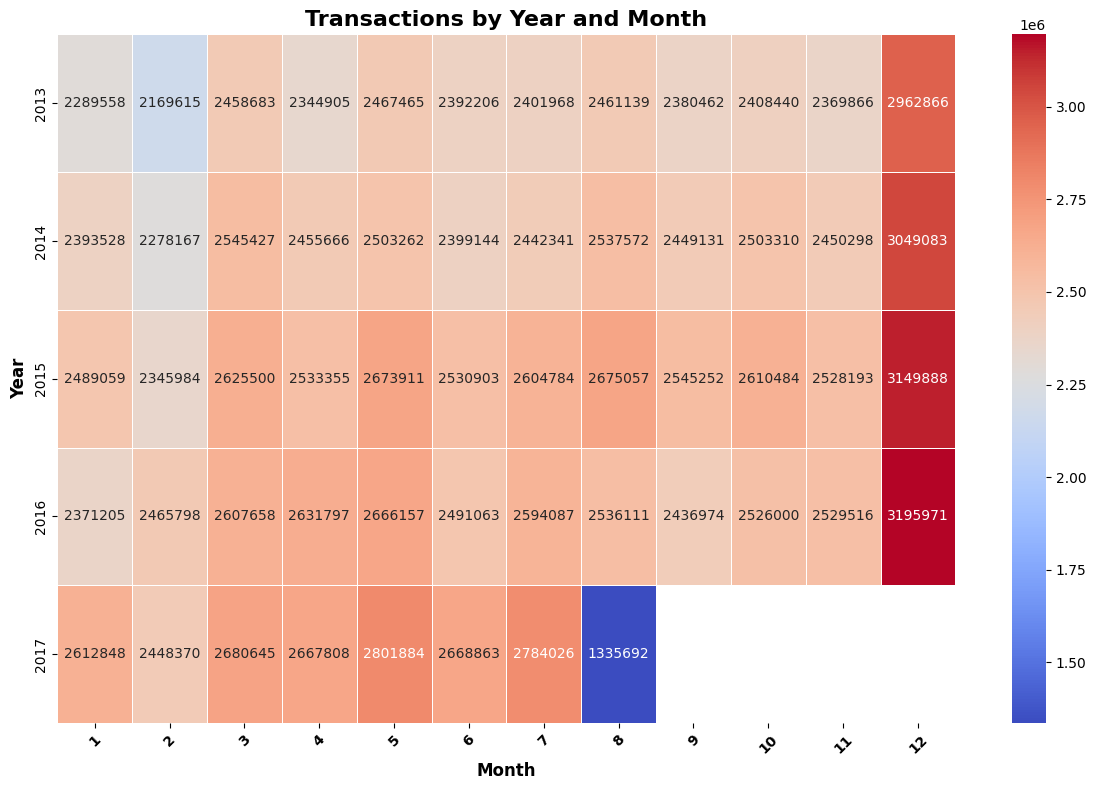

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# make sure time dimension extraction
transactions_df = transactions.copy()
transactions_df["year"] = transactions_df.date.dt.year
transactions_df["month"] = transactions_df.date.dt.month
transactions_df["year_month"] = transactions_df["year"].astype(str) + "-" + transactions_df["month"].astype(str).str.zfill(2)

# In order to make a heat map, you first need to convert the data into a pivot table of years and months
pivot_table = transactions_df.pivot_table(index='year', columns='month', values='transactions', aggfunc='sum')

# Use sns.heatmap to draw heat maps
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".0f", linewidths=.5)

# Set chart title and axis labels
plt.title('Transactions by Year and Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Year', fontsize=12, fontweight='bold')

# Adjust axis scale style
plt.xticks(fontsize=10, fontweight='bold', rotation=45)
plt.yticks(fontsize=10)

# Adjust layout
plt.tight_layout()

# display chart
plt.show()


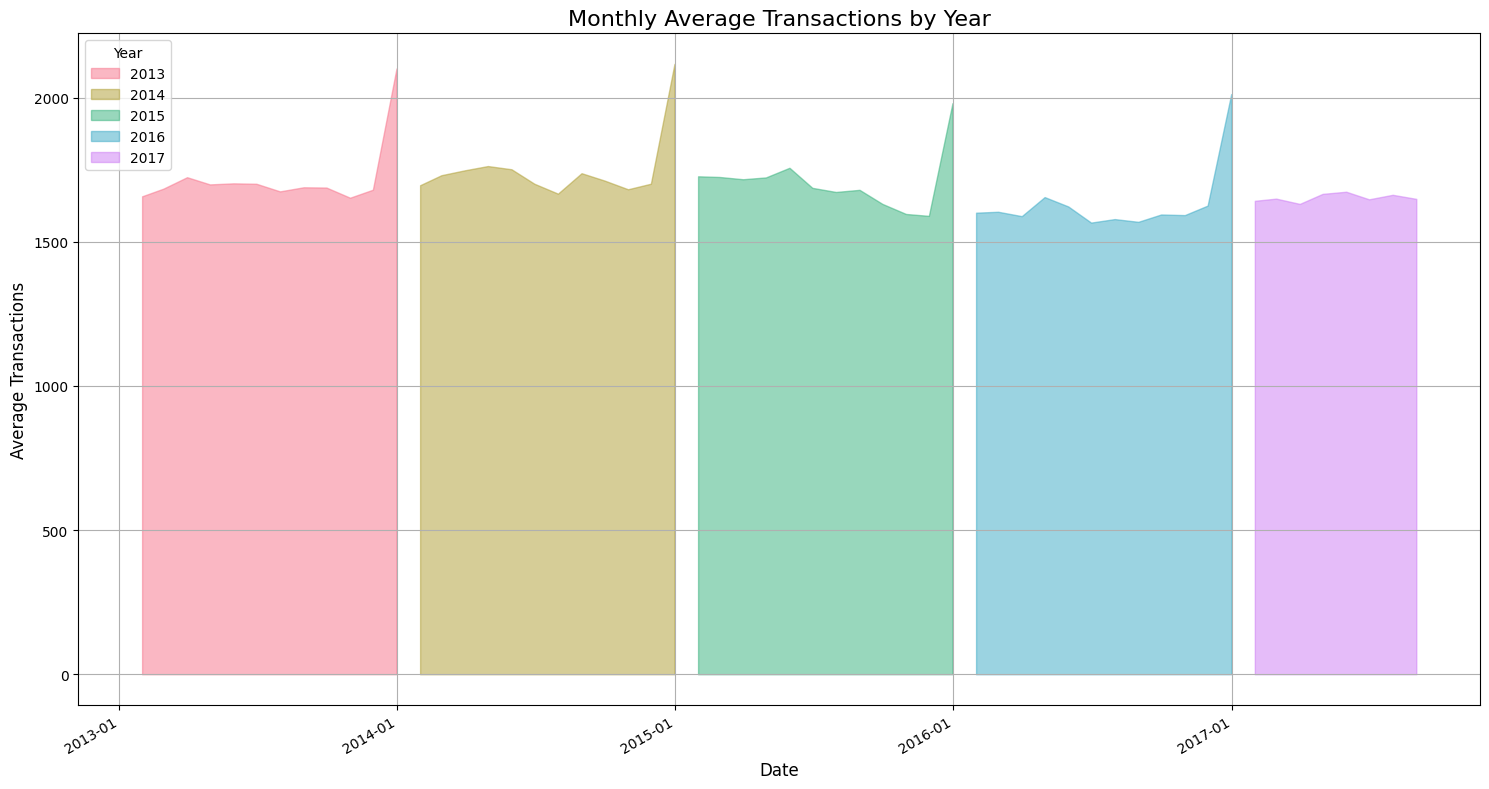

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Resample the data to get the average monthly transaction volume
monthly_avg_transactions = transactions.set_index("date").resample("ME").transactions.mean().reset_index()

# Extract the year for subsequent grouping
monthly_avg_transactions["year"] = monthly_avg_transactions.date.dt.year

# Set graphic size
plt.figure(figsize=(15, 8))

# Set colors for different years using seaborn's color palette
palette = sns.color_palette("husl", len(monthly_avg_transactions['year'].unique()))

# Group and plot by year
for i, (year, group) in enumerate(monthly_avg_transactions.groupby('year')):
    plt.fill_between(group['date'], group['transactions'], label=year, color=palette[i], alpha=0.5)

plt.title('Monthly Average Transactions by Year', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Transactions', fontsize=12)

# Improve formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Format x-axis scale to year-month
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set the x-axis scale at the beginning of each year
plt.gcf().autofmt_xdate()  # Rotate date labels for better spacing
plt.legend(title='Year', loc='upper left')  #Add legend and set title

# show grid
plt.grid(True)

# Display graphics
plt.tight_layout()
plt.show()


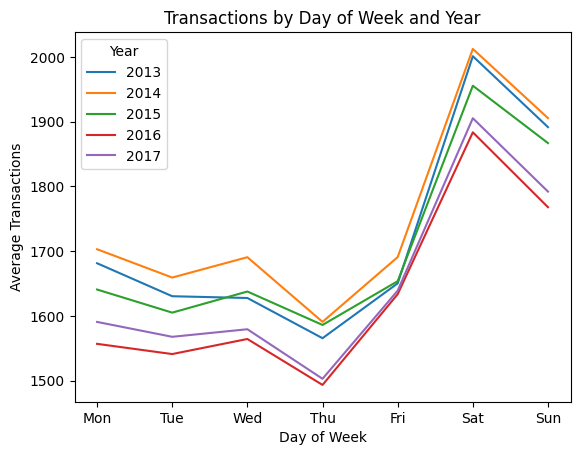

In [8]:
import matplotlib.pyplot as plt

weekly_transactions = transactions.copy()
weekly_transactions["year"] = weekly_transactions.date.dt.year
weekly_transactions["dayofweek"] = weekly_transactions.date.dt.dayofweek + 1  # 将星期天从0变为1，星期六为7
weekly_transactions = weekly_transactions.groupby(["year", "dayofweek"])["transactions"].mean().reset_index()

fig, ax = plt.subplots()

# For each year in the data, draw a line
for year in weekly_transactions["year"].unique():
    df_year = weekly_transactions[weekly_transactions["year"] == year]
    ax.plot(df_year["dayofweek"], df_year["transactions"], label=str(year))

ax.set_xlabel("Day of Week")
ax.set_ylabel("Average Transactions")
ax.set_title("Transactions by Day of Week and Year")
ax.legend(title="Year")

plt.xticks(ticks=range(1, 8), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  # 设置x轴的刻度标签为星期几
plt.show()


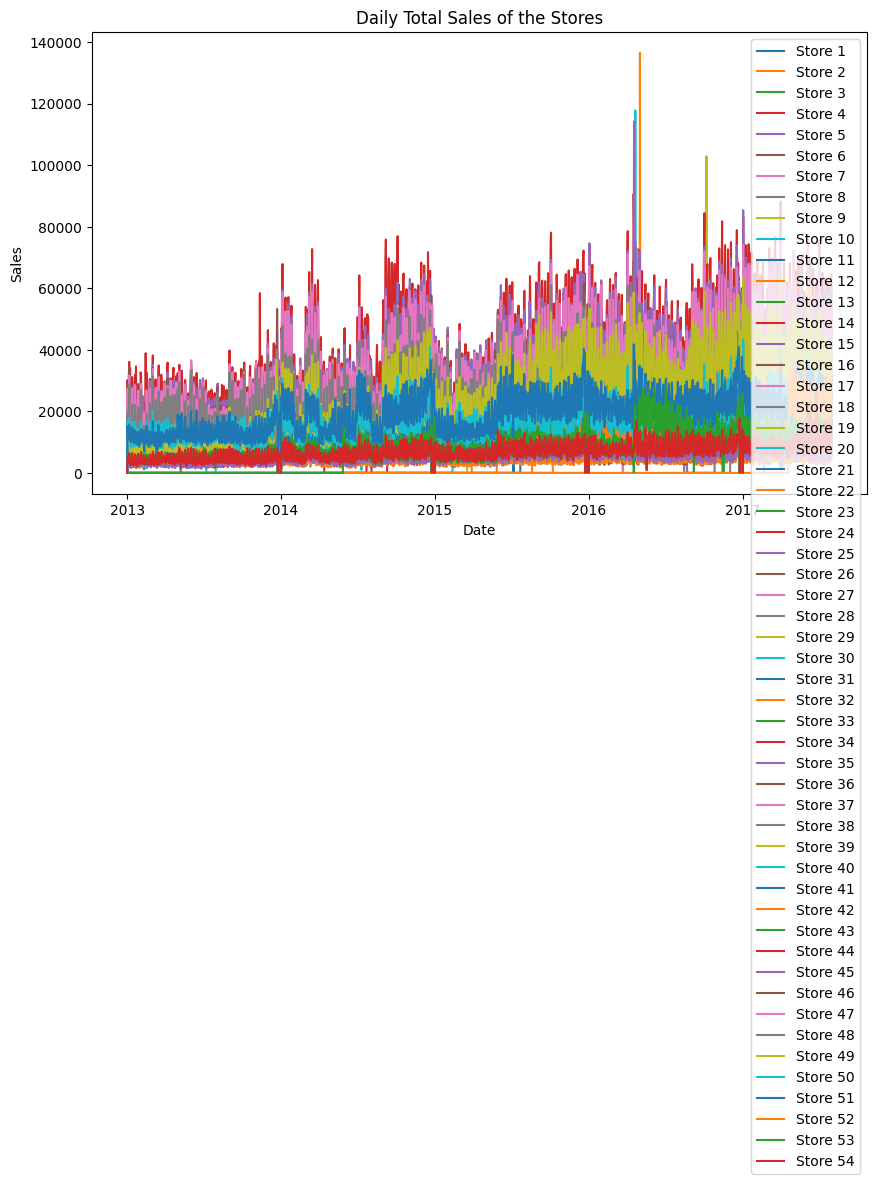

In [9]:
import matplotlib.pyplot as plt
df = train_df.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()

plt.figure(figsize=(10, 6))

# Draw data for each store through loop
for store in df['store_nbr'].unique():
    store_data = df[df['store_nbr'] == store]
    plt.plot(store_data['date'], store_data['sales'], label=f'Store {store}')

plt.legend()

plt.title("Daily Total Sales of the Stores")
plt.xlabel("Date")
plt.ylabel("Sales")

plt.show()



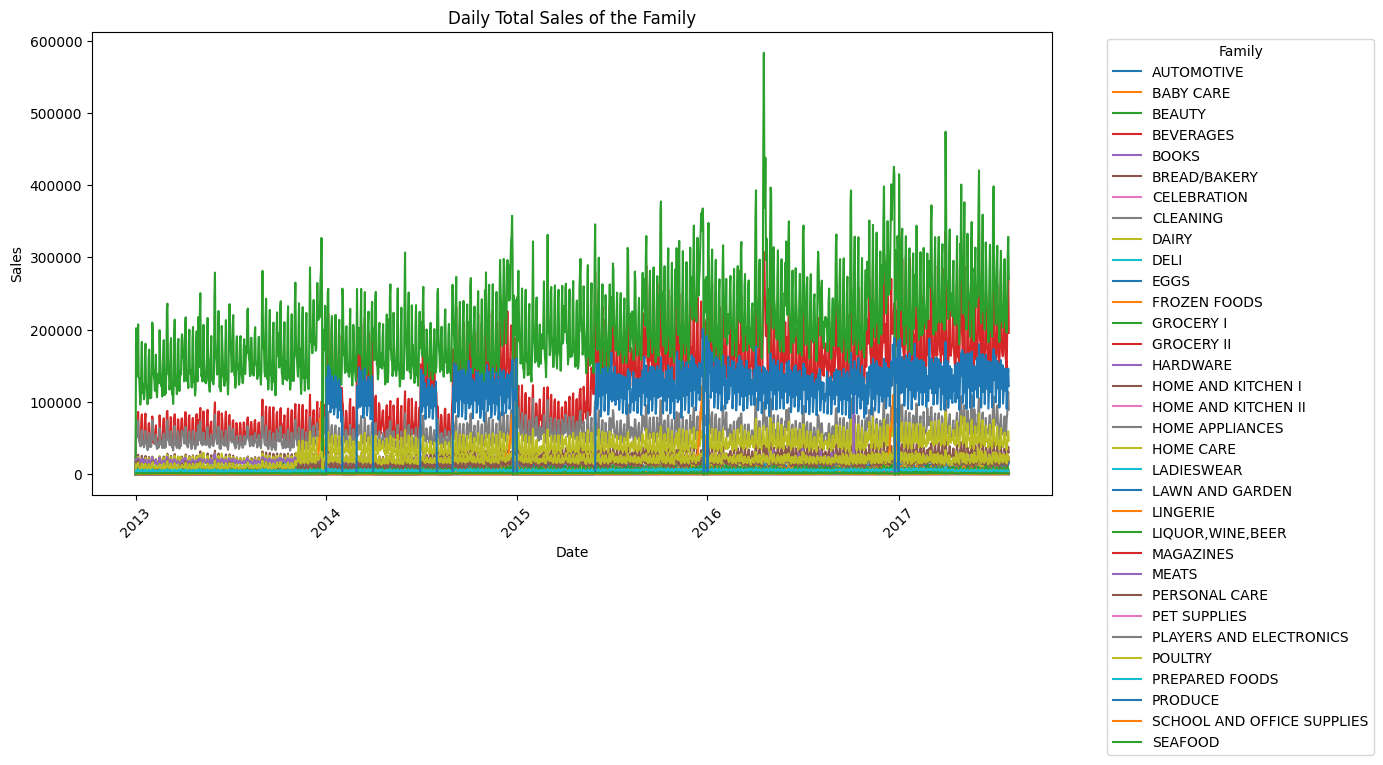

In [10]:
import matplotlib.pyplot as plt

# Pivot the data to get "Family" in the column and index it by date
df = train_df.set_index("date").groupby("family").resample("D").sales.sum().reset_index()
df_pivot = df.pivot(index='date', columns='family', values='sales')

plt.figure(figsize=(14, 7))  

# Plot each family's sales over time
for family in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[family], label=family)

# Add title and labels
plt.title('Daily Total Sales of the Family')
plt.xlabel('Date')
plt.ylabel('Sales')

# Add legend
plt.legend(title='Family', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate the x-axis date
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  
plt.show()


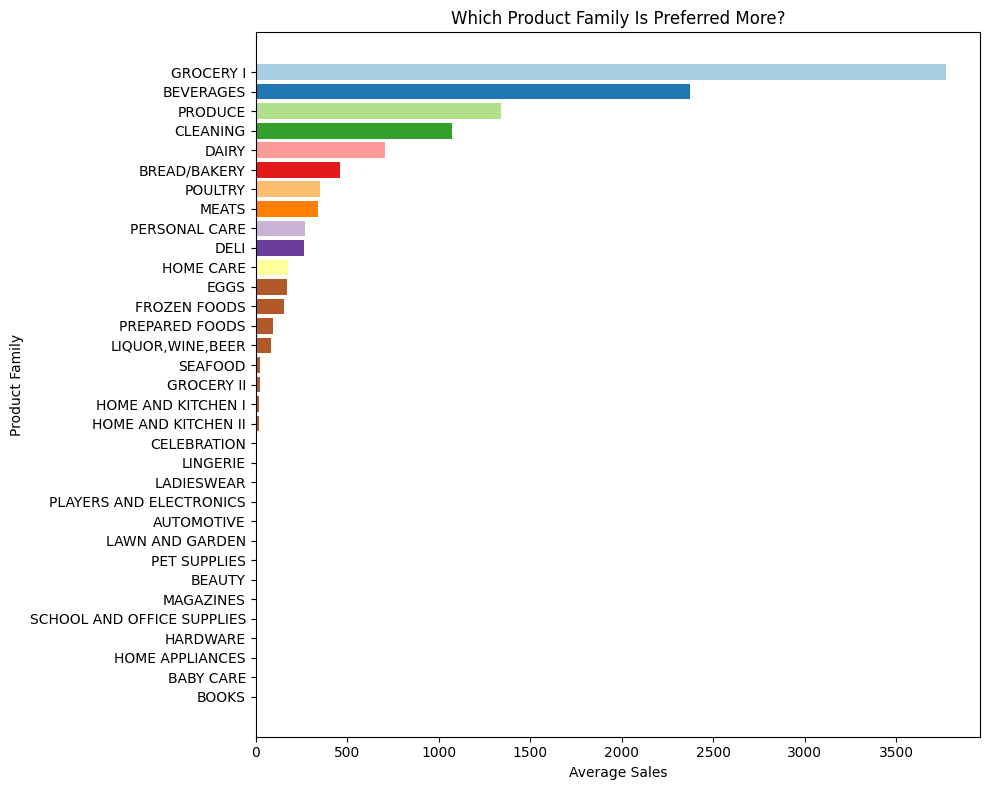

In [11]:
import matplotlib.pyplot as plt

# First, group by 'family' and calculate the mean sales, then sort in descending order
df = train_df.groupby("family").sales.mean().sort_values(ascending=False).reset_index()

# Now, let's create a horizontal bar chart using matplotlib
plt.figure(figsize=(10, 8))  # Set the figure size
plt.barh(df['family'], df['sales'], color=plt.cm.Paired(range(len(df))))  # Use a colormap for the bars

# Adding the title to the plot
plt.title("Which Product Family Is Preferred More?")

# Adding labels to the axes
plt.xlabel("Average Sales")
plt.ylabel("Product Family")

# Inverting the y-axis to show the largest bar on top
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()  
plt.show()


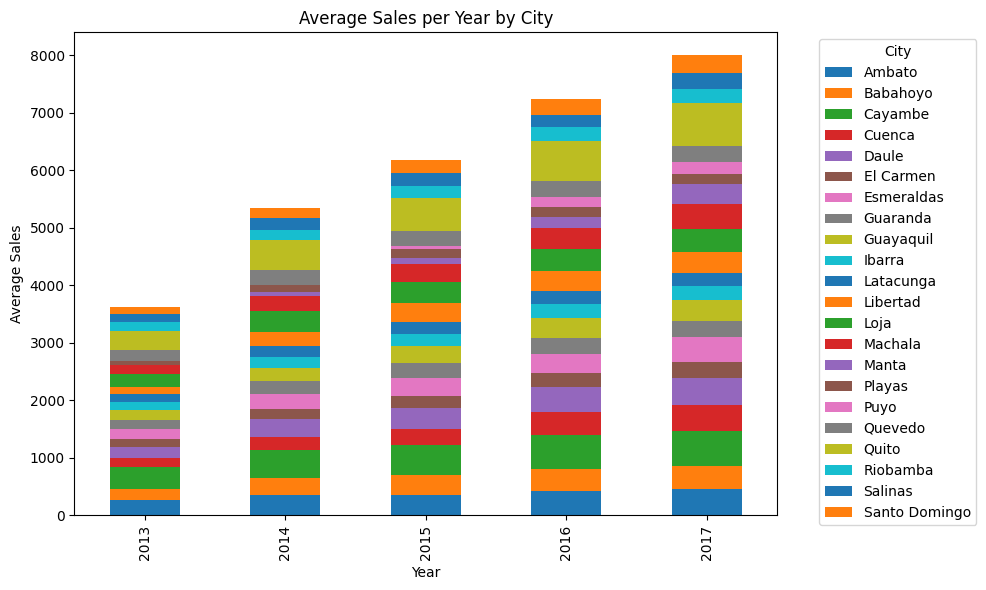

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure data merge
df = pd.merge(train_df, store_df)
df["store_nbr"] = df["store_nbr"].astype("int8")
df["year"] = df.date.dt.year

# Group by city and year, calculate average sales
grouped_df = df.groupby(["city", "year"]).sales.mean().reset_index()

# Create a pivot table where city is the column and year is the index
pivot_df = grouped_df.pivot(index='year', columns='city', values='sales')

# Draw a stacked column chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add chart title and axis labels
plt.title('Average Sales per Year by City')
plt.xlabel('Year')
plt.ylabel('Average Sales')

# Show legend
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

# Optimize layout
plt.tight_layout()

plt.show()


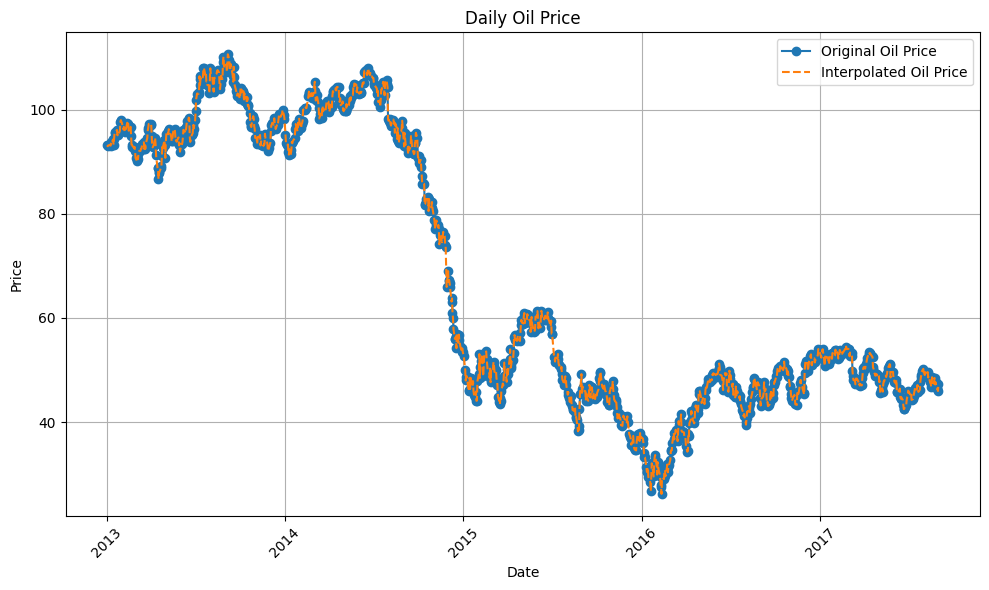

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set date as index
oil['date'] = pd.to_datetime(oil['date'])
oil = oil.set_index('date')

# Resample to daily and fill in nulls if needed
oil_resampled = oil.resample('D').first()
oil_resampled['dcoilwtico'] = np.where(oil_resampled['dcoilwtico'].isnull(), np.nan, oil_resampled['dcoilwtico'])
oil_resampled['dcoilwtico_interpolated'] = oil_resampled['dcoilwtico'].interpolate()

# drawing
plt.figure(figsize=(10, 6))
plt.plot(oil_resampled.index, oil_resampled['dcoilwtico'], label='Original Oil Price', marker='o')
plt.plot(oil_resampled.index, oil_resampled['dcoilwtico_interpolated'], label='Interpolated Oil Price', linestyle='--')

plt.title('Daily Oil Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## LightGBM Model

### Initializing a LightGBM Regression Model

- **Set Boosting Type to Gradient Boosted Decision Trees (GBDT)**
  - Because it is an efficient ensemble learning algorithm that reduces model bias by iteratively adding decision trees, suitable for various regression and classification tasks.

- **Set Task Type to Regression**
  - The goal of regression tasks is to predict a continuous value. In sales forecasting, we focus on accurately predicting the magnitude of a quantity, thus choosing regression as the task type.

- **Set Evaluation Metrics to L1 Loss (Mean Absolute Error) and L2 Loss (Mean Squared Error)**
  - These metrics evaluate model error from different perspectives, helping to fully understand model performance.

- **Randomly Select 90% of Features for Training in Each Iteration**
  - Using a subset of features in each training iteration can increase the model's generalization ability and reduce the risk of overfitting.

- **Use 70% of Data for Each Iteration**
  - Another technique to reduce overfitting and enhance model generalization ability.

- **Perform Bagging Every 10 Iterations**
  - Setting the frequency of bagging adjusts the extent of data sampling by the model, finding a balance point to reduce overfitting and improve model generalization ability.

- **Set to 0, No Training Information Output**
  - Allows focusing more on the model's final results and performance metrics.



In [14]:
import lightgbm as lgb

model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression',
                          metric=['l1', 'l2'], feature_fraction=0.9,
                          bagging_fraction=0.7, bagging_freq=10,
                          verbose=0)

In [15]:
from sklearn.model_selection import GridSearchCV, KFold
# The selection of [0.04, 0.05, 0.06] as the candidate value of the learning rate parameter is based on previous experience, 
# the need to avoid overfitting and underfitting, 
# the intention of careful parameter tuning, 
# the control while optimizing computing resources and time costs. 
# Stability of model training.
param_grid = {
    'learning_rate': [0.04,0.05,0.06],
}

#Initialize the GridSearchCV object
# - estimator=model: use previously defined model as estimator
# - param_grid=param_grid: Specify the parameter grid defined above
# - cv=5: Use 5-fold cross validation
# - scoring='neg_mean_squared_error': Use negative mean squared error as the scoring criterion, because GridSearchCV defaults to the bigger the better,
# And we want to minimize the mean square error, so use negative values
# - verbose=1: Print detailed information during the search process
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', verbose=1)
# Fit GridSearchCV on the training set
# - X_train: Characteristics of training data
# - y_train: target variable of training data
grid_search.fit(X_train, y_train)

print('Best learning rate:', grid_search.best_params_['learning_rate'])


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0

In [16]:
# Initialize a LightGBM regression model
model = lgb.LGBMRegressor(boosting_type='gbdt',
                          objective='regression',
                          metric=['l1', 'l2'],
                          learning_rate=0.06,
                          feature_fraction=0.9,
                          bagging_fraction=0.7,
                          bagging_freq=10,
                          verbose=0)

In [17]:
# The selection of [185, 190, 195] as a candidate value for num_leaves is based on previous experience, 
# the need for fine-grained tuning, computational resource considerations, 
# and the purpose of finding a balance between avoiding overfitting and maintaining model complexity.
param_grid = {
    'num_leaves': [185,190,195], 
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

print('Best parameters found by grid search are:', grid_search.best_params_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_fr

In [18]:
model = lgb.LGBMRegressor(boosting_type='gbdt', 
                          objective='regression', 
                          metric=['l1', 'l2'], 
                          learning_rate=0.06,
                          feature_fraction=0.9, 
                          bagging_fraction=0.7, 
                          bagging_freq=10, 
                          verbose=0, 
                          num_leaves=190, 
                          )

#This range of max_depth candidate values was chosen to fine-tune the depth of the model to find an optimal tree depth that strikes a balance between preventing overfitting and ensuring that the model is complex enough to capture data relationships, taking into account Tradeoff between computational efficiency and model performance.
param_grid = {
    'max_depth': [8,9,10,11]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_absolute_error', verbose=1)
grid_search.fit(X_train, y_train)

print('Best parameters found by grid search are:', grid_search.best_params_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [19]:
import json

#Define the hyperparameters of the LightGBM model
hyper_params = {
                
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': ['l1','l2'],
                'learning_rate': 0.06,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.7,
                'bagging_freq': 10,
                'verbose': 0,
                "max_depth": 9,
                "num_leaves": 190,
                "max_bin": 512,}

# Initialize the LGBMRegressor model and pass in the defined hyperparameters
gbm = lgb.LGBMRegressor(**hyper_params)

# Fit the model using the training data and evaluate it on the validation set
# Evaluation set
# Use L1 loss as evaluation metric
gbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='l1')

# Print the top 10 most important features
feature_importances = gbm.feature_importances_
top_n = 10 # Set the number of important features to display
sorted_idx = feature_importances.argsort()[-top_n:]
print("Top", top_n, "Feature importances:")
for idx in sorted_idx:
    print(f"Feature {idx} importance: {feature_importances[idx]}")

#Save model structure to JSON file
with open("model_structure.json", "w") as f:
    json.dump(gbm.booster_.dump_model(), f, indent=4)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_fr

In [20]:
y_pred = gbm.predict(X_val)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


In [21]:
# Convert y_pred to a pandas Series for consistency
y_pred_series = pd.Series(y_pred, name='y_pred')

# Reset the index of y_val to align with y_pred's index
y_val_reset = y_val.reset_index(drop=True)

# Concatenate y_val and y_pred into a new DataFrame
results = pd.concat([y_val_reset, y_pred_series], axis=1)
results.columns = ['y_val', 'y_pred']  # Renaming the columns for clarity

# Clip y_pred to ensure predictions are non-negative
results['y_pred'] = results['y_pred'].clip(lower=0)

# Filter the results to keep rows where y_val is greater than 10
results_filtered = results[results['y_val'] > 10]

# Display the final filtered results
print(results_filtered)

           y_val       y_pred
3         47.000    55.412997
5        137.341   121.771735
6        286.000   255.816253
9        172.965   163.239656
10        85.264    87.909236
...          ...          ...
605163   470.513   443.556300
605164    61.940   108.680389
605165  1517.552  1671.586570
605166    56.000    37.323333
605167    12.000    18.965963

[367358 rows x 2 columns]


In [22]:
y_pred = gbm.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


In [23]:

# Create a DataFrame for output with 'id' from data_test as index and 'y_pred' as sales predictions
predict = pd.DataFrame({'id': data_test['id'], 'sales': y_pred})
# Ensure all sales predictions are non-negative
predict['sales'] = predict['sales'].clip(lower=0)
print(predict.columns)
test = test.loc[:, ['id', 'sales']]
print(test.columns)

Index(['id', 'sales'], dtype='object')
Index(['id', 'sales'], dtype='object')


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calculate the absolute difference between actual and predicted sales for each ID, creating a list of differences
diff_list = [(id_, abs(test.loc[test['id'] == id_]['sales'].values[0] - 
                       predict.loc[predict['id'] == id_]['sales'].values[0])) 
             for id_ in test['id'].unique()]

# Find the record with the maximum difference from the list of differences
max_diff = max(diff_list, key=lambda x: x[1])

# Find the record with the minimum difference from the list of differences
min_diff = min(diff_list, key=lambda x: x[1])

# Calculate the average of the differences
mean_diff = np.mean([diff for _, diff in diff_list])

# Extract the actual and predicted sales from the test set and predictions
actual_sales = test['sales']
predicted_sales = predict['sales']

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_sales, predicted_sales))

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_sales, predicted_sales)

# Calculate the average of the actual and predicted sales
mean_actual_sales = np.mean(actual_sales)
mean_predicted_sales = np.mean(predicted_sales)

# Find the maximum and minimum actual sales
max_sales = max(actual_sales)
min_sales = min(actual_sales)

# Print the results
print("Highest sales:", max_sales)
print("Lowest sales:", min_sales)
print("ID with the largest difference (sales):", max_diff)
print("ID with the smallest difference (sales):", min_diff)#print("Mean difference between actual and predicted sales:", mean_diff)
print("Mean of actual sales:", mean_actual_sales)
print("Mean of predicted sales:", mean_predicted_sales)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Highest sales: 15190.0
Lowest sales: 0.0
ID with the largest difference (sales): (2994432, 4942.334729014141)
ID with the smallest difference (sales): (2985464, 0.001369188419131362)
Mean of actual sales: 465.144891162645
Mean of predicted sales: 473.89765281101353
Root Mean Squared Error (RMSE): 206.29307911872536
Mean Absolute Error (MAE): 63.957204707718454


## Prophet model for transactions and sales prediction

We leverage the Prophet model to predict future store sales by training directly on the entire combined dataset. This approach is based on several key features and capabilities inherent to the Prophet model, which together alleviate the need for traditional train-test splits:

- **Cross-Validation**: Prophet includes built-in cross-validation functionality that allows us to evaluate model performance across different ranges without the need for a separate test set. This method simulates forecasts over historical periods and compares them to actual values, providing a robust measure of model forecast accuracy.

- **Handling Missing Data**: Prophet can handle missing data by automatically imputing it, ensuring that gaps in the data set do not hinder the model's ability to learn from the available data. This feature is particularly useful in real-world data sets where missing values are common.

- **Automatic Seasonality Detection**: The model is able to automatically detect and adjust for multiple seasonal patterns in the data, eliminating the need to manually select seasonality based on training data. This ensures that the model captures both obvious and subtle seasonal effects across the entire dataset.

- **HOLIDAY IMPACT**: Prophet allows the inclusion of holidays and special events, allowing the model to account for irregular but predictable effects on sales. This feature is critical for accurate forecasting in a retail environment, as holidays can significantly impact sales.

- **Trend Change Identification**: This model skillfully identifies trend change points in time series data and adapts to changes in sales patterns over time. This dynamic adjustment is critical for long-term forecasts, where trends can change due to external factors.

- **Scalability**: Prophet's scalability ensures that it can handle large datasets such as `combined_train_df` efficiently, so there is no need to reduce the dataset size via train-test split for computational reasons.

By training on the entire dataset, we ensure that the model makes full use of the available data and captures its complex patterns and relationships. This comprehensive approach, powered by Prophet’s advanced capabilities, is designed to generate the most accurate and versatile sales forecasts possible, maximizing the model’s predictive power for strategic decisions.

d:\MySQL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
17:31:44 - cmdstanpy - INFO - Chain [1] start processing
17:31:45 - cmdstanpy - INFO - Chain [1] done processing
d:\MySQL\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\MySQL\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydate

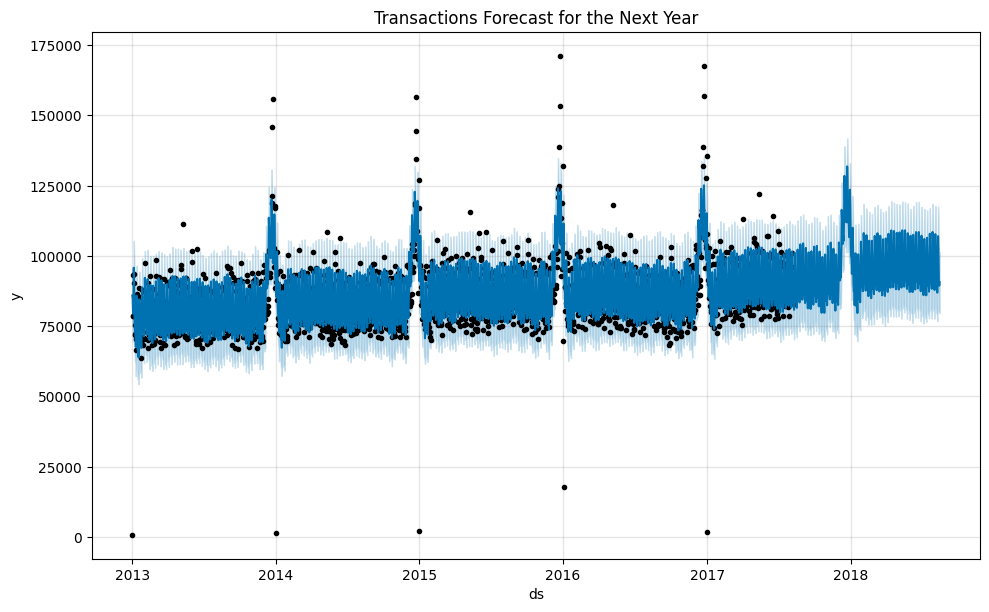

In [25]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Make sure 'date' is in datetime format
sorted = transactions_df.sort_values(["year", "month"])
sorted['date'] = pd.to_datetime(sorted['date'])

# Group data by date and sum transactions for each day
daily_transactions = sorted.groupby('date')['transactions'].sum().reset_index()

# Rename the columns for Prophet compatibility
daily_transactions.rename(columns={'date': 'ds', 'transactions': 'y'}, inplace=True)

# Initialize the Prophet model
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(daily_transactions)

# Create a future dataframe for the next 365 days
future = model.make_future_dataframe(periods=365)

# Predict the future transactions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title("Transactions Forecast for the Next Year")
plt.show()


17:31:52 - cmdstanpy - INFO - Chain [1] start processing
17:31:53 - cmdstanpy - INFO - Chain [1] done processing
d:\MySQL\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\MySQL\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


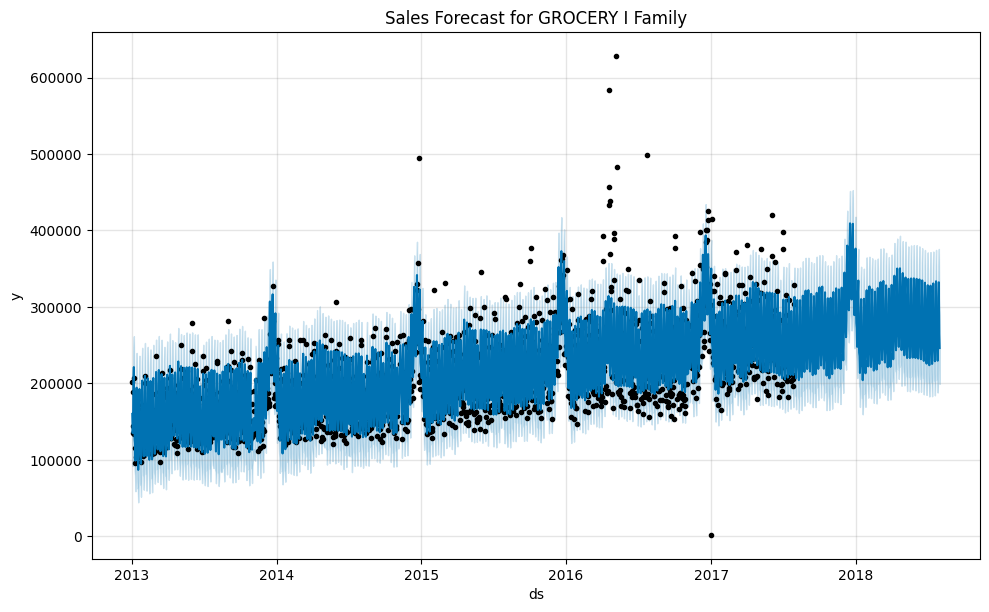

In [26]:
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np


# Reverting the one-hot encoding for the 'family' column to identify 'GROCERY I'
combined_train_df['family'] = np.select(
    [combined_train_df['family_GROCERY I'] == 1], 
    ['GROCERY I'], 
    default='OTHER'
)

# Filtering to keep only the 'GROCERY I' family
grocery_i_df = combined_train_df[combined_train_df['family'] == 'GROCERY I']

# Grouping the data by date and summing up the sales to get daily sales data for 'GROCERY I'
grocery_i_sales_df = grocery_i_df.groupby('date')['sales'].sum().reset_index()

# Renaming columns for Prophet
grocery_i_sales_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Initializing the Prophet model
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(grocery_i_sales_df)

# Creating a future dataframe for prediction
future = model.make_future_dataframe(periods=365)  # Predict the next 365 days

# Predicting
forecast = model.predict(future)

# Plotting the forecast
fig = model.plot(forecast)
plt.title("Sales Forecast for GROCERY I Family")
plt.show()


17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:32:00 - cmdstanpy - INFO - Chain [1] done processing
d:\MySQL\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\MySQL\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Text(0.5, 1.0, 'Sales Forecast for BEVERAGES Family')

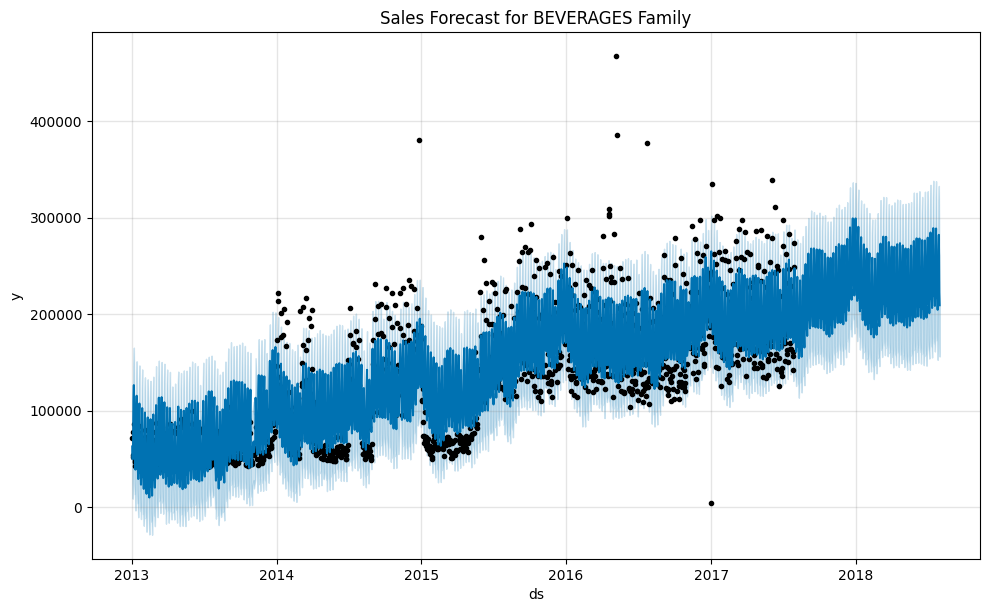

In [27]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Mark the rows with 1 in the family_BEVERAGES column as 'BEVERAGES' and the remaining rows as 'OTHER' through the np.select function. This is because the original family column was encoded with one click and needs to be restored in order to filter specific product categories.
combined_train_df['family'] = np.select(
    [combined_train_df['family_BEVERAGES'] == 1], 
    ['BEVERAGES'], 
    default='OTHER'
)

# conditional filtering is used to retain only the rows whose family column is 'BEVERAGES' and create a new DataFrame beverages_df.
beverages_df = combined_train_df[combined_train_df['family'] == 'BEVERAGES']

# the data will be aggregated according to the date column, and the sales of each date will be summed to obtain the total daily sales data.
beverages_sales_df = beverages_df.groupby('date')['sales'].sum().reset_index()

# The Prophet model requires the column names in the data frame to be ds (date) and y (prediction target), so this code renames the column names from date and sales to ds and y.
beverages_sales_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# a Prophet model instance is created, daily seasonality is turned off, annual seasonality is turned on, and then the beverages_sales_df data set is used to fit the model.
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(beverages_sales_df)

# Create a data frame for future predictions
future = model.make_future_dataframe(periods=365) 

# Predict
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title("Sales Forecast for BEVERAGES Family")


17:32:04 - cmdstanpy - INFO - Chain [1] start processing
17:32:06 - cmdstanpy - INFO - Chain [1] done processing
d:\MySQL\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\MySQL\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


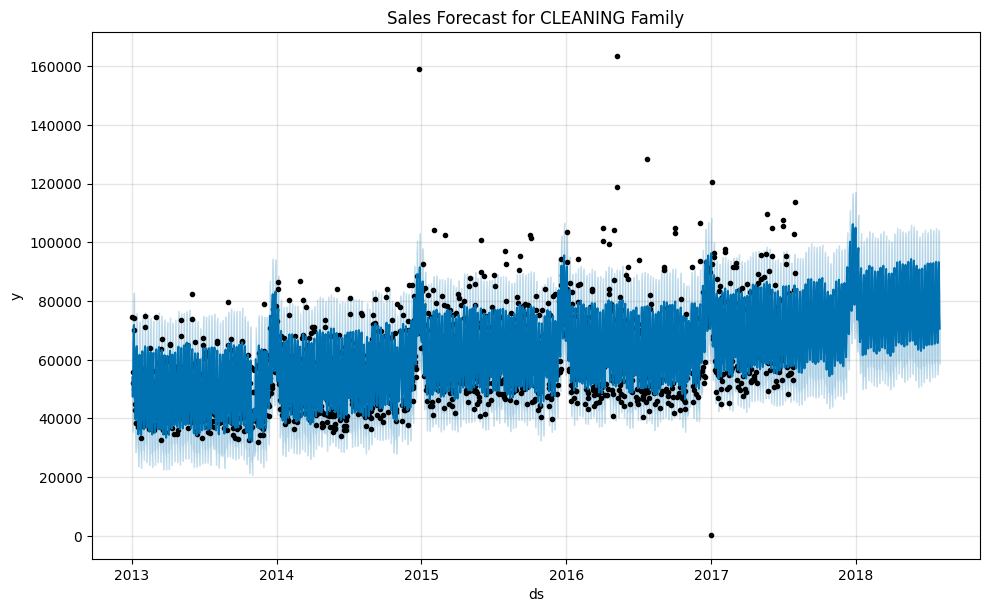

In [28]:
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

# Reverting the one-hot encoding for the 'family' column to identify 'CLEANING'
combined_train_df['family'] = np.select(
    [combined_train_df['family_CLEANING'] == 1], 
    ['CLEANING'], 
    default='OTHER'
)

# Filtering to keep only the 'CLEANING' family
cleaning_df = combined_train_df[combined_train_df['family'] == 'CLEANING']

# Grouping the data by date and summing up the sales to get daily sales data for 'CLEANING'
cleaning_sales_df = cleaning_df.groupby('date')['sales'].sum().reset_index()

# Renaming columns for Prophet
cleaning_sales_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Initializing the Prophet model
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(cleaning_sales_df)

# Creating a future dataframe for prediction
future = model.make_future_dataframe(periods=365)  # Predict the next 365 days

# Predicting
forecast = model.predict(future)

# Plotting the forecast
fig = model.plot(forecast)
plt.title("Sales Forecast for CLEANING Family")
plt.show()


17:32:10 - cmdstanpy - INFO - Chain [1] start processing
17:32:11 - cmdstanpy - INFO - Chain [1] done processing
d:\MySQL\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\MySQL\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


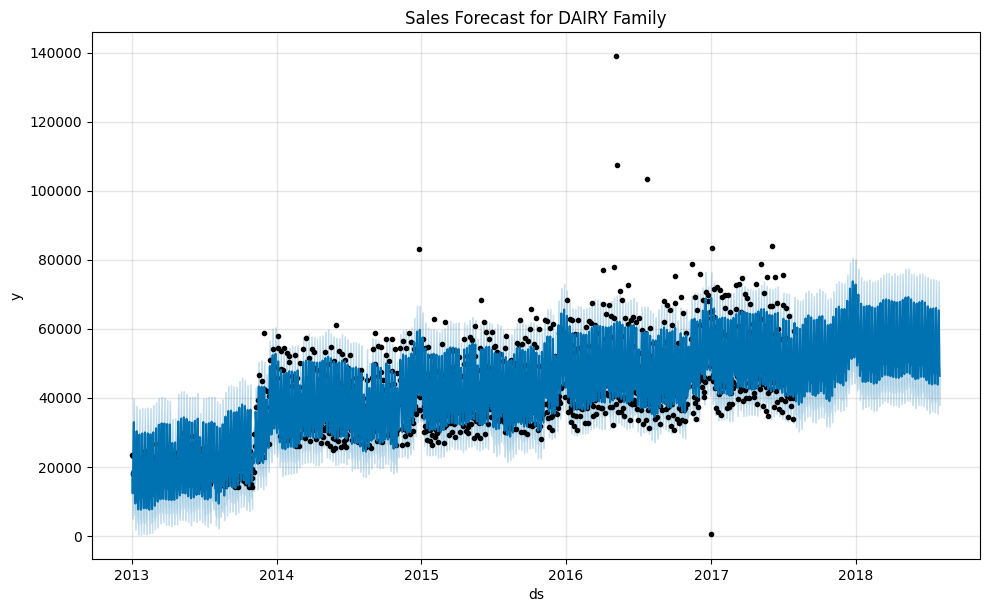

In [29]:
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

# Reverse one-hot encoding to identify 'DAIRY' in column 'family'
combined_train_df['family'] = np.select(
    [combined_train_df['family_DAIRY'] == 1], 
    ['DAIRY'], 
    default='OTHER'
)

# Filter out only data containing 'family' as 'DAIRY'
dairy_df = combined_train_df[combined_train_df['family'] == 'DAIRY']

# Group by date and sum the 'sales' column to get the total sales for each day for the 'DAIRY' family
dairy_sales_df = dairy_df.groupby('date')['sales'].sum().reset_index()

# Rename columns for Prophet model
dairy_sales_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Initialize the Prophet model
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(dairy_sales_df)

# Create a future data frame for forecasting (forecasting the next 365 days)
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# Draw prediction chart
fig = model.plot(forecast)
plt.title("Sales Forecast for DAIRY Family")
plt.show()


17:32:36 - cmdstanpy - INFO - Chain [1] start processing
17:32:38 - cmdstanpy - INFO - Chain [1] done processing
d:\MySQL\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\MySQL\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


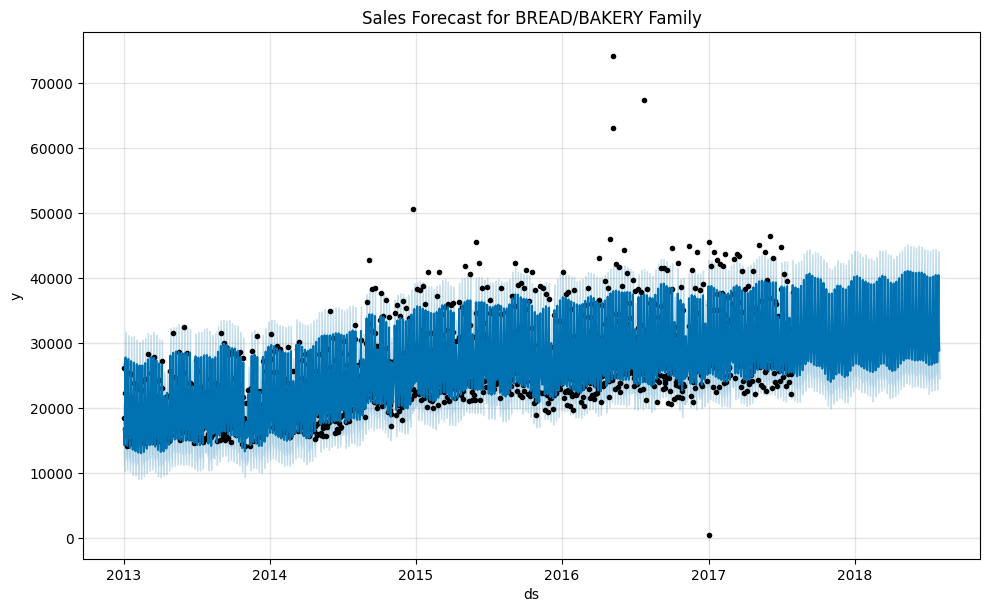

In [30]:
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

#Identify 'BREAD/BAKERY' family through reverse one-hot encoding of np.select function
combined_train_df['family'] = np.select(
    [combined_train_df['family_BREAD/BAKERY'] == 1], 
    ['BREAD/BAKERY'], 
    default='OTHER'
)

# Filter out rows whose family is 'BREAD/BAKERY'
bread_bakery_df = combined_train_df[combined_train_df['family'] == 'BREAD/BAKERY']

# Get daily sales data for the 'BREAD/BAKERY' family by grouping by date and calculating total sales
bread_bakery_sales_df = bread_bakery_df.groupby('date')['sales'].sum().reset_index()

# Prepare data for Prophet model, rename columns to 'ds' and 'y'
bread_bakery_sales_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Initialize the Prophet model, turn off daily seasonality, and turn on yearly seasonality.
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(bread_bakery_sales_df)

# Create a future date data frame for forecasting
future = model.make_future_dataframe(periods=365) 

# make predictions
forecast = model.predict(future)

# Plot prediction results
fig = model.plot(forecast)
plt.title("Sales Forecast for BREAD/BAKERY Family")
plt.show()


17:32:43 - cmdstanpy - INFO - Chain [1] start processing
17:32:44 - cmdstanpy - INFO - Chain [1] done processing
d:\MySQL\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\MySQL\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


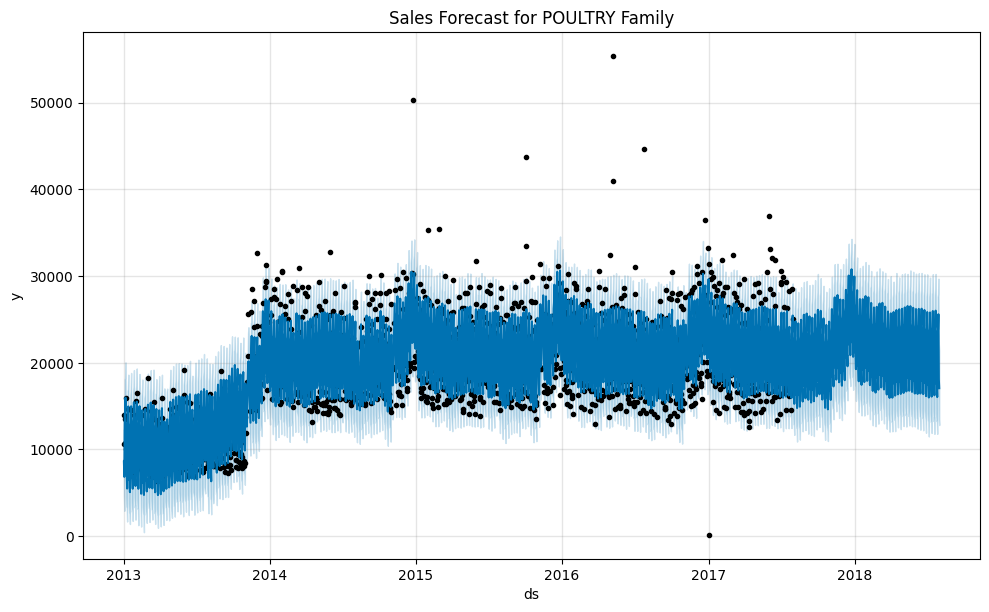

In [31]:
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

# Reverse one-hot encoding to identify 'POULTRY' in column 'family'
combined_train_df['family'] = np.select(
    [combined_train_df['family_POULTRY'] == 1], 
    ['POULTRY'], 
    default='OTHER'
)

# Filter out rows whose family is 'POULTRY'
poultry_df = combined_train_df[combined_train_df['family'] == 'POULTRY']

# Get daily sales data for 'POULTRY' family by grouping by date and calculating total sales
poultry_sales_df = poultry_df.groupby('date')['sales'].sum().reset_index()

# Prepare data for Prophet model, rename columns to 'ds' and 'y'
poultry_sales_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Initialize the Prophet model, turn off daily seasonality, and turn on yearly seasonality.
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(poultry_sales_df)

# Create a future date data frame for prediction
future = model.make_future_dataframe(periods=365)  

# Make predictions
forecast = model.predict(future)

# Draw prediction results
fig = model.plot(forecast)
plt.title("Sales Forecast for POULTRY Family")
plt.show()


17:32:49 - cmdstanpy - INFO - Chain [1] start processing
17:32:50 - cmdstanpy - INFO - Chain [1] done processing
d:\MySQL\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\MySQL\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


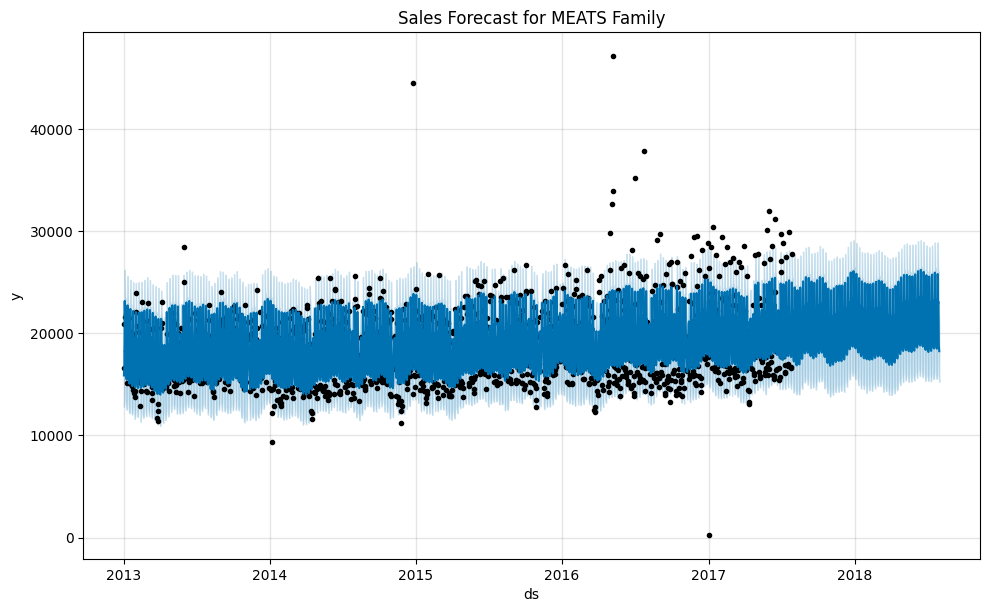

In [32]:
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

# Reverse one-hot encoding to identify 'MEATS' in the 'family' column
combined_train_df['family'] = np.select(
    [combined_train_df['family_MEATS'] == 1], 
    ['MEATS'], 
    default='OTHER'
)

# Filter out rows whose family is 'MEATS'
meats_df = combined_train_df[combined_train_df['family'] == 'MEATS']

# Group by date and calculate total sales, get daily sales data of 'MEATS' family
meats_sales_df = meats_df.groupby('date')['sales'].sum().reset_index()

# Prepare data for the Prophet model, rename the columns to 'ds' and 'y'
meats_sales_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Initialize the Prophet model, turn off daily seasonality, and turn on yearly seasonality
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(meats_sales_df)

# Create a future date data frame for prediction.
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)
# Draw prediction results
fig = model.plot(forecast)
plt.title("Sales Forecast for MEATS Family")
plt.show()


17:32:55 - cmdstanpy - INFO - Chain [1] start processing
17:32:56 - cmdstanpy - INFO - Chain [1] done processing
d:\MySQL\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\MySQL\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


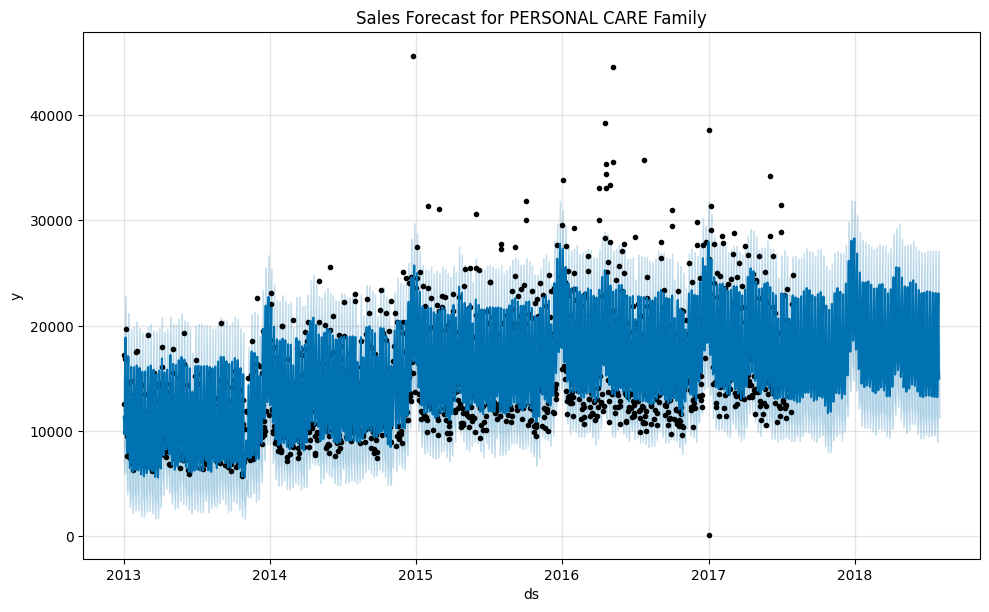

In [33]:
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np


# Reverse one-hot encoding to identify 'PERSONAL CARE' in the 'family' column
combined_train_df['family'] = np.select(
    [combined_train_df['family_PERSONAL CARE'] == 1], 
    ['PERSONAL CARE'], 
    default='OTHER'
)

# Filter out rows whose family is 'PERSONAL CARE'
personal_care_df = combined_train_df[combined_train_df['family'] == 'PERSONAL CARE']

#Group by date and calculate the total sales to obtain the daily sales data of the 'PERSONAL CARE' family
personal_care_sales_df = personal_care_df.groupby('date')['sales'].sum().reset_index()

# Prepare data for the Prophet model, rename the columns to 'ds' and 'y'
personal_care_sales_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Initialize the Prophet model, turn off daily seasonality, and turn on yearly seasonality
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(personal_care_sales_df)

# Create a future date data frame for prediction.
future = model.make_future_dataframe(periods=365)
# Make predictions
forecast = model.predict(future)

#draw
fig = model.plot(forecast)
plt.title("Sales Forecast for PERSONAL CARE Family")
plt.show()


17:33:00 - cmdstanpy - INFO - Chain [1] start processing
17:33:01 - cmdstanpy - INFO - Chain [1] done processing
d:\MySQL\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\MySQL\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


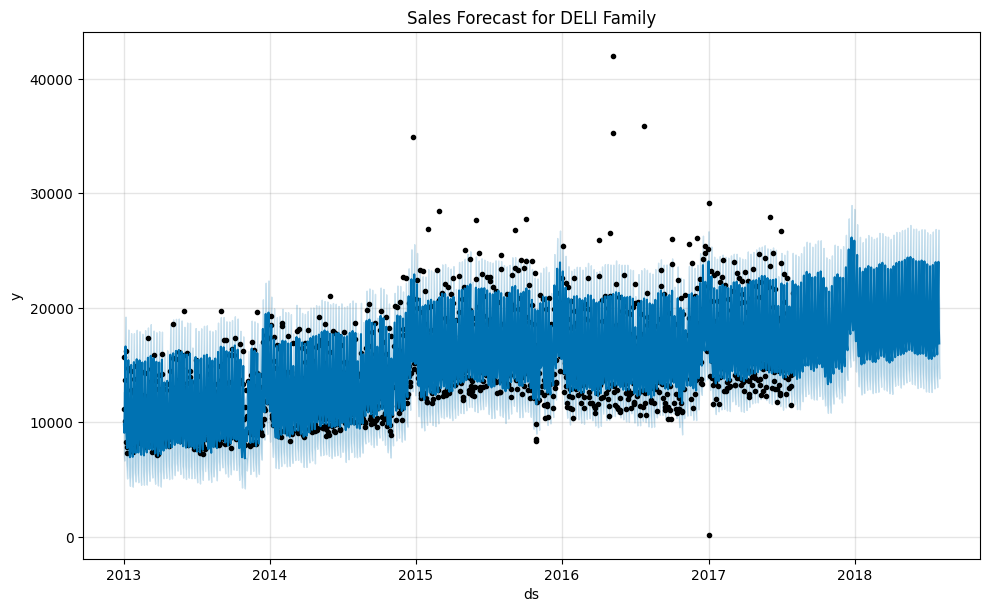

In [34]:
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

# Reverse one-hot encoding to identify 'DELI' in the 'family' column
combined_train_df['family'] = np.select(
    [combined_train_df['family_DELI'] == 1], 
    ['DELI'], 
    default='OTHER'
)

# Filter out rows whose family is 'DELI'
deli_df = combined_train_df[combined_train_df['family'] == 'DELI']

#Group by date and calculate total sales to obtain daily sales data for the 'DELI' family
deli_sales_df = deli_df.groupby('date')['sales'].sum().reset_index()

# Prepare data for the Prophet model, rename the columns to 'ds' and 'y'
deli_sales_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Initialize the Prophet model, turn off daily seasonality, and turn on yearly seasonality
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(deli_sales_df)
# Create a future date data frame for prediction
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# draw
fig = model.plot(forecast)
plt.title("Sales Forecast for DELI Family")
plt.show()


17:33:06 - cmdstanpy - INFO - Chain [1] start processing
17:33:08 - cmdstanpy - INFO - Chain [1] done processing
d:\MySQL\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\MySQL\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


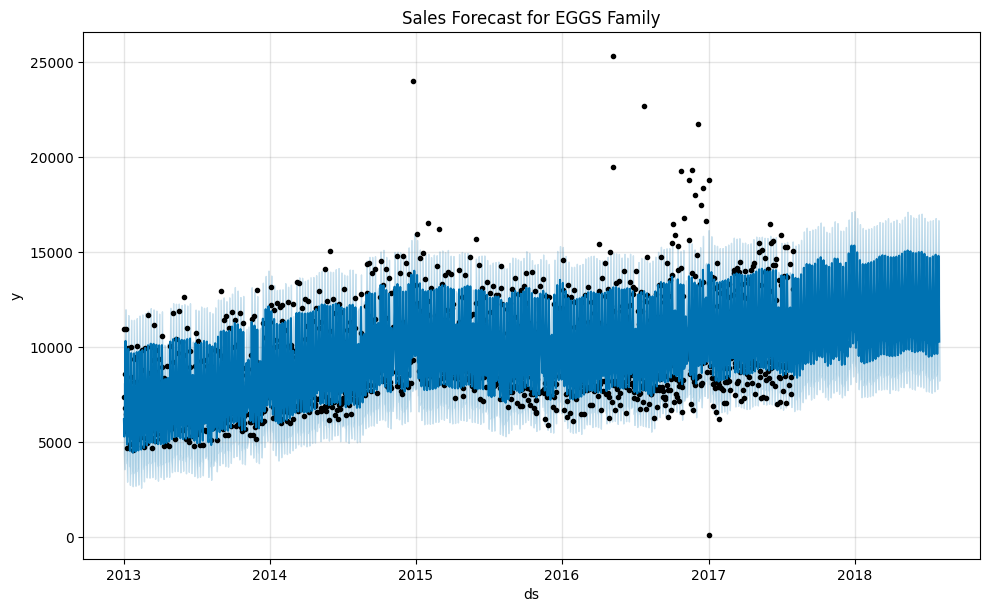

In [35]:
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np


# Reverse one-hot encoding to identify 'EGGS' in the 'family' column
combined_train_df['family'] = np.select(
    [combined_train_df['family_EGGS'] == 1], 
    ['EGGS'], 
    default='OTHER'
)

# Filter out rows whose family is 'EGGS'
eggs_df = combined_train_df[combined_train_df['family'] == 'EGGS']

# Group by date and calculate the total sales, get the daily sales data of the 'EGGS' family
eggs_sales_df = eggs_df.groupby('date')['sales'].sum().reset_index()

# Prepare data for the Prophet model, rename the columns to 'ds' and 'y'
eggs_sales_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Initialize the Prophet model, turn off daily seasonality, and turn on yearly seasonality
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(eggs_sales_df)

# Create a future date data frame for prediction
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# draw
fig = model.plot(forecast)
plt.title("Sales Forecast for EGGS Family")
plt.show()


17:33:13 - cmdstanpy - INFO - Chain [1] start processing
17:33:14 - cmdstanpy - INFO - Chain [1] done processing
d:\MySQL\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\MySQL\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


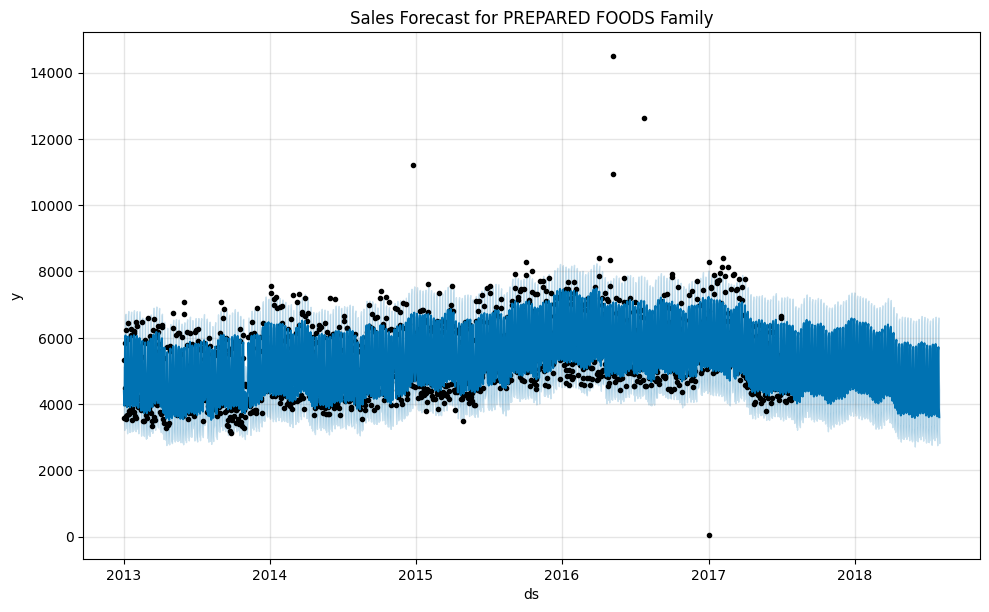

In [36]:
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

# Reverse one-hot encoding to identify 'PREPARED FOODS' in the 'family' column
combined_train_df['family'] = np.select(
    [combined_train_df['family_PREPARED FOODS'] == 1], 
    ['PREPARED FOODS'], 
    default='OTHER'
)

# Filter out rows whose family is 'PREPARED FOODS'
prepared_foods_df = combined_train_df[combined_train_df['family'] == 'PREPARED FOODS']

# Group by date and calculate total sales, get daily sales data for 'PREPARED FOODS' family
prepared_foods_sales_df = prepared_foods_df.groupby('date')['sales'].sum().reset_index()

# Prepare data for Prophet model, rename columns to 'ds' and 'y'
prepared_foods_sales_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Initialize the Prophet model, turn off daily seasonality, and turn on yearly seasonality.
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(prepared_foods_sales_df)

# Create a future date data frame for forecasting
future = model.make_future_dataframe(periods=365)

# make predictions
forecast = model.predict(future)

# draw
fig = model.plot(forecast)
plt.title("Sales Forecast for PREPARED FOODS Family")
plt.show()


17:33:19 - cmdstanpy - INFO - Chain [1] start processing
17:33:20 - cmdstanpy - INFO - Chain [1] done processing
d:\MySQL\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\MySQL\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


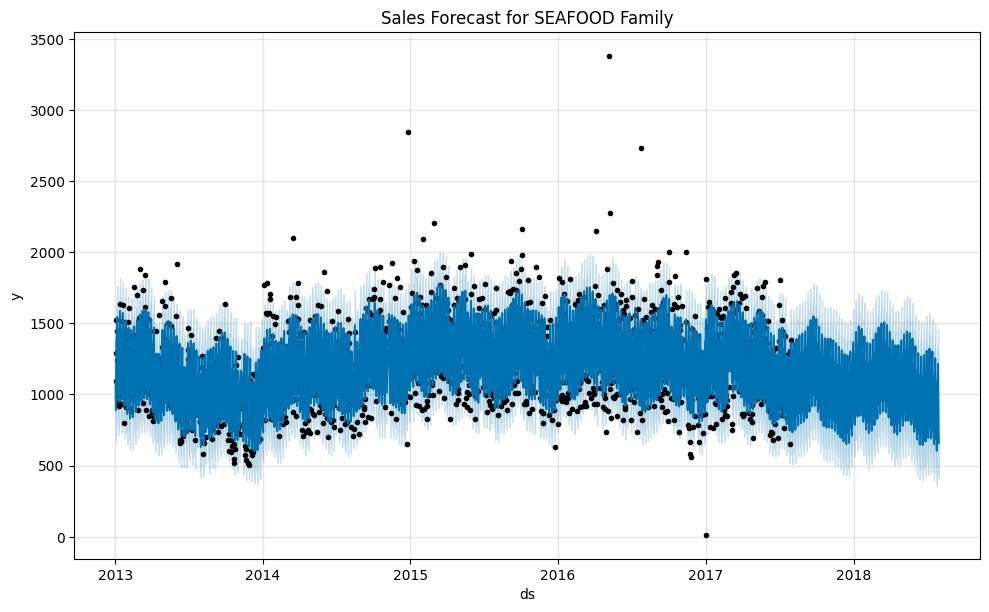

In [37]:
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np


# Reverting the one-hot encoding for the 'family' column to identify 'SEAFOOD'
combined_train_df['family'] = np.select(
    [combined_train_df['family_SEAFOOD'] == 1], 
    ['SEAFOOD'], 
    default='OTHER'
)

# Filtering to keep only the 'SEAFOOD' family
seafood_df = combined_train_df[combined_train_df['family'] == 'SEAFOOD']

# Grouping the data by date and summing up the sales to get daily sales data for 'SEAFOOD'
seafood_sales_df = seafood_df.groupby('date')['sales'].sum().reset_index()

# Renaming columns for Prophet
seafood_sales_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Initializing the Prophet model
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(seafood_sales_df)

# Creating a future dataframe for prediction
future = model.make_future_dataframe(periods=365)  

# Predicting
forecast = model.predict(future)

# Plotting the forecast
fig = model.plot(forecast)
plt.title("Sales Forecast for SEAFOOD Family")
plt.show()
